In [1]:
import pathlib
import datetime

import pint
import dateutil.parser
import numpy as np
import pandas as pd

import scipy.interpolate

import matplotlib.pyplot as plt

ureg = pint.UnitRegistry()

%matplotlib inline

In [2]:
# TODO: replace with 2017 figures (from HKV update)
# These are the SLR measurements averaged over 6 tide gauges
mean_sl_path = pathlib.Path('~/src/sealevel-svn/editorial/2018/mean_sl_plot.csv').expanduser()
mean_sl_path = pathlib.Path('~/src/sealevel/notebooks/dutch-sea-level-monitor-export-2019-09-29.csv').expanduser()
# these are the polygons as used in figure 3.26 in KNMI 2014 scenario
knmi_scenarios_path = pathlib.Path('~/src/sealevel/data/knmi/KNMI14_sealevel_scenarios_by_1year_3polfit.csv').expanduser()

In [3]:
# read the polynomials from the KNMI scenarios
knmi_df = pd.read_csv(knmi_scenarios_path)
# convert to m for consistency
for var in ['low_05', 'low_95', 'high_05', 'high_95']:
    knmi_df[var + '_m'] = (knmi_df[var].values * ureg.centimeter).to(ureg.meter)
knmi_df.tail()

,year,low_05,low_95,high_05,high_95,comment,low_05_m,low_95_m,high_05_m,high_95_m
101,2096,26.9,71.7,48.7,93.5,KNMI14 scenarios; Created as 3rd order polynom...,0.269,0.717,0.487,0.935
102,2097,27.1,72.7,49.3,94.9,KNMI14 scenarios; Created as 3rd order polynom...,0.271,0.727,0.493,0.949
103,2098,27.3,73.7,49.8,96.2,KNMI14 scenarios; Created as 3rd order polynom...,0.273,0.737,0.498,0.962
104,2099,27.5,74.7,50.4,97.5,KNMI14 scenarios; Created as 3rd order polynom...,0.275,0.747,0.504,0.975
105,2100,27.7,75.7,50.9,98.9,KNMI14 scenarios; Created as 3rd order polynom...,0.277,0.757,0.509,0.989


0.05583333333333333

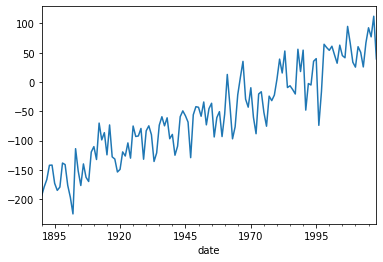

In [4]:
# read all the scenarios
# slr_df = pd.read_csv(mean_sl_path)
slr_df = pd.read_csv(mean_sl_path, comment='#', parse_dates=['date'])

# slr_df['date'] = slr_df['year'].apply(lambda x:dateutil.parser.parse(x))
slr_df = slr_df.set_index('date')
# convert to units
height_mm = slr_df['height'].values * ureg.millimeter
height_m = height_mm.to(ureg.meter)
slr_df['height_m'] = height_m
slr_df['height'].plot()


def mean_sl_between_years(df, a, b):
    """return the mean waterlevel in m for a <= period < b"""
    index = np.logical_and(
        df.index >= datetime.datetime(a, 1, 1),
        df.index < datetime.datetime(b, 1, 1)
    )
    waterlevel = df[index].mean(axis=0)['height_m']
    return waterlevel
mean_sl_between_years(slr_df, 2016, 2017) - mean_sl_between_years(slr_df, 1986, 2005)

# Explained versus unexplained variance
The figure below shows the measurements before and after accounting for wind and nodal tide. These figures show that the annual variation reduces when correcting for wind and tide. This can be seen by the dots which are closer to the line in the second figure. Remaining variance can be caused by the lack of accuracy of our wind correction and by other causes (ROFI, NOA, AMO, etc...)

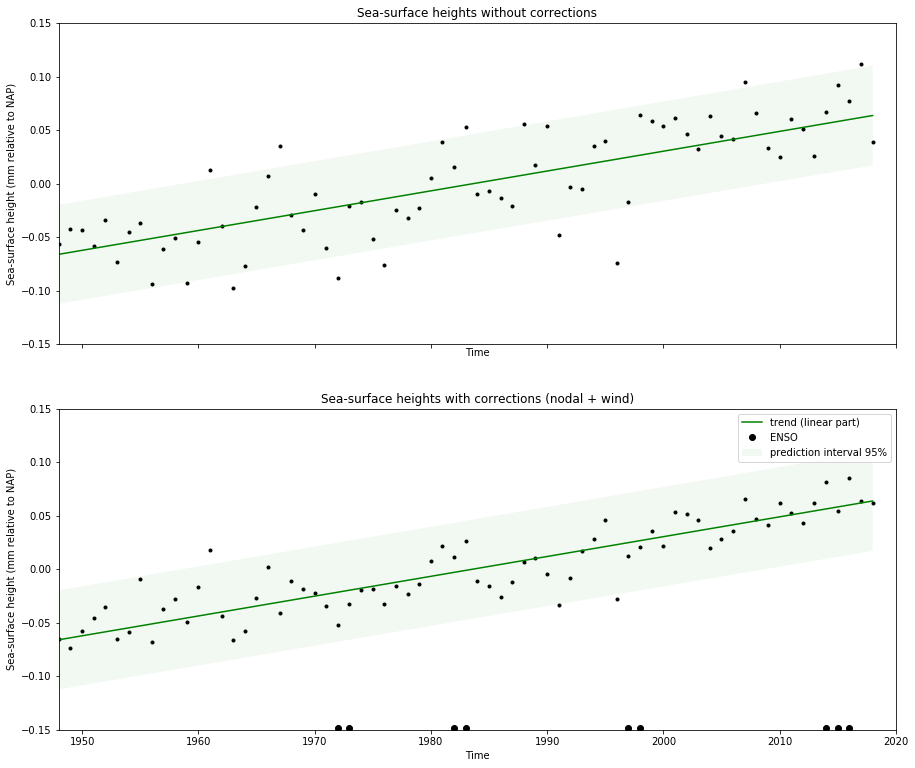

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 13), sharex=True, sharey=True)
wind_correction = slr_df.predicted_linear_with_wind - slr_df.predicted_linear_mean_wind 
ensos = [datetime.datetime(year, 1, 1) for year in [1925, 1926, 1972, 1973, 1982, 1983, 1997, 1998, 2014, 2015, 2016]]


axes[0].plot(slr_df.index, slr_df.height / 1000, 'k.')
axes[1].plot((slr_df.height - wind_correction) / 1000, 'k.')


for ax in axes:
    ax.plot(
        slr_df.index, 
        slr_df.predicted_linear_mean_wind / 1000, 
        color='green', 
        label='trend (linear part)'
    )

    ax.fill_between(
        slr_df.index, 
        slr_df.predicted_linear_mean_wind_pi_025 / 1000, 
        slr_df.predicted_linear_mean_wind_pi_975 / 1000, 
        alpha=0.05, 
        facecolor='green', 
        label='prediction interval 95%'
    )
axes[0].set_ylim(-0.15, 0.15)
axes[1].plot(ensos, [-0.148 for x in ensos], 'ko', label='ENSO')
# no wind correction before this date
axes[0].set_xlim(datetime.datetime(1948, 1, 1), datetime.datetime(2020, 1, 1))

axes[0].set_title('Sea-surface heights without corrections')
axes[1].set_title('Sea-surface heights with corrections (nodal + wind)')
axes[0].set_ylabel('Sea-surface height (mm relative to NAP)')
axes[1].set_ylabel('Sea-surface height (mm relative to NAP)')
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[1].legend()


In [6]:
def correct_subsidence_and_epoch(dates, ssh, subsidence_rate=0.00045):
    delta_years_since_epoch = np.array([
        (date_i - datetime.datetime(1995, 1, 1)).days / 365.25
        for date_i 
        in dates
    ])
    # both KNMI and AR5 scenario's are absolute sea-level rise. 
    # tide gauges measure relative sea-level rise
    # add subsidence to the scenario's to make them comparable
    subsidence = delta_years_since_epoch * subsidence_rate
    # scenario's show sea level anomalies, relative to an epoch 
    # for AR5 and KNMI that is the mean sea-level between 1986-2005
    ssh_at_epoch = mean_sl_between_years(slr_df, 1986, 2005) 
    return ssh + ssh_at_epoch + subsidence

# IPCC 2013 AR5 - reference year 1986-2005 (1995.5, plotted on 1995)
# Table 13.5 in Chapter 13
records = []

meta = {
    "organization": "IPCC",
    "name": "AR5",
    # scenario started in this period
    "correction": correct_subsidence_and_epoch,
    "years": np.array([1995, 2055, 2100])
}
record = {**meta}
record["scenario"] = "A1B"
record['min'] = np.array([0, 0.19, 0.43])  
record['mean'] = np.array([0, 0.27, 0.60])
record['max'] = np.array([0, 0.34, 0.8])
records.append(record)

record = {**meta}
record["scenario"] = "rcp26"
record['min'] = np.array([0, 0.17, 0.28])
record['mean'] = np.array([0, 0.24, 0.44])
record['max'] = np.array([0, 0.32, 0.61])
records.append(record)

record = {**meta}
record["scenario"] = "rcp45"
record['min'] = np.array([0, 0.19, 0.36])
record['mean'] = np.array([0, 0.26, 0.53])
record['max'] = np.array([0, 0.33, 0.71])
records.append(record)

record = {**meta}
record["scenario"] = "rcp60"
record['min'] = np.array([0, 0.18, 0.38])
record['mean'] = np.array([0, 0.25, 0.55])
record['max'] = np.array([0, 0.32, 0.73])
records.append(record)

record = {**meta}
record["scenario"] = "rcp85"
record['min'] = np.array([0, 0.22, 0.52])
record['mean'] = np.array([0, 0.30, 0.74])
record['max'] = np.array([0, 0.38, 0.98])
records.append(record)



# KNMI 2014, as used in table 3.2 and figure 3.26
# based on data from KNMI 
meta = {
    "organization": "KNMI",
    "name": "2014",
    # scenario are sea level anomaly with respect to 1986-2005
    # scenario's only include absolute sea-level rise, so subtract subsidence
    "correction": correct_subsidence_and_epoch,
    "years": knmi_df.year.values
}

record = {**meta}
record["scenario"] = "low"
record['min']= knmi_df.low_05_m
record['mean']= (knmi_df.low_05_m + knmi_df.low_95_m) / 2
record['max'] = knmi_df.low_95_m
records.append(record)

record = {**meta}
record["scenario"] = "high"
record['min']= knmi_df.high_05_m
record['mean']= (knmi_df.high_05_m + knmi_df.high_95_m) / 2
record['max'] = knmi_df.high_95_m
records.append(record)

In [7]:
# add spline interpolation
for record in records:
    x = np.arange(record['years'][0], record['years'][-1])
    dates = [datetime.datetime(x_i, 1, 1) for x_i in x]
    record['interp_dates'] = np.array(dates)
    for stat in ['min', 'mean', 'max']:
        fun = scipy.interpolate.UnivariateSpline(record['years'], record[stat], k=2)
        interp = fun(x)
        record['interp_' + stat] = interp

scenarios_df = pd.DataFrame(records)
scenarios_df['dates'] = scenarios_df['years'].apply(lambda x: np.array([datetime.datetime(x_i, 1, 1) for x_i in x]))


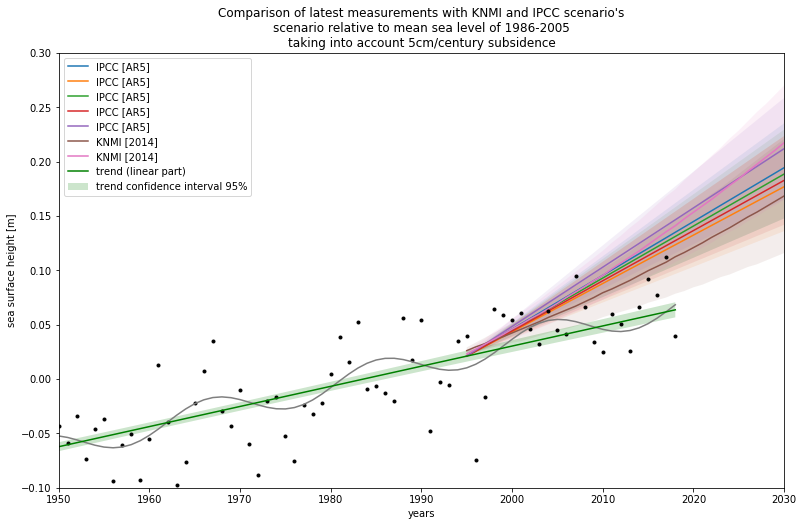

In [8]:
fig, ax = plt.subplots(figsize=(13, 8))
for i, row in scenarios_df.iterrows():
    ax.fill_between(
        row['dates'], 
        row['correction'](row['dates'], row['min']), 
        row['correction'](row['dates'], row['max']), 
        alpha=0.1
    )
    ax.plot(
        row['dates'], 
        row['correction'](row['dates'], row['mean']),
        label = '{} [{}]'.format(row['organization'], row['name'])
    )
ax.set_xlabel('years')
ax.set_ylabel('sea surface height [m]')
ax.plot(slr_df.index, slr_df['height_m'], 'k.')   
ax.plot(slr_df.index, slr_df['predicted_linear'] / 1000)
ax.plot(slr_df.index, slr_df.predicted_linear_mean_wind / 1000, color='green', label='trend (linear part)')

ax.fill_between(
    slr_df.index, slr_df.predicted_linear_mean_wind_ci_025/1000, 
    slr_df.predicted_linear_mean_wind_ci_975/1000, 
    alpha=0.2, 
    facecolor='green', 
    label='trend confidence interval 95%'
)

ax.set_title(
    "Comparison of latest measurements with KNMI and IPCC scenario\'s" + 
    "\n" + 
    "scenario relative to mean sea level of 1986-2005" + 
    "\n" +
    "taking into account 5cm/century subsidence"
)

ax.set_xlim(datetime.datetime(1950, 1, 1), datetime.datetime(2030, 1, 1))
ax.set_ylim(-0.1, 0.3)
ax.legend(loc='best')

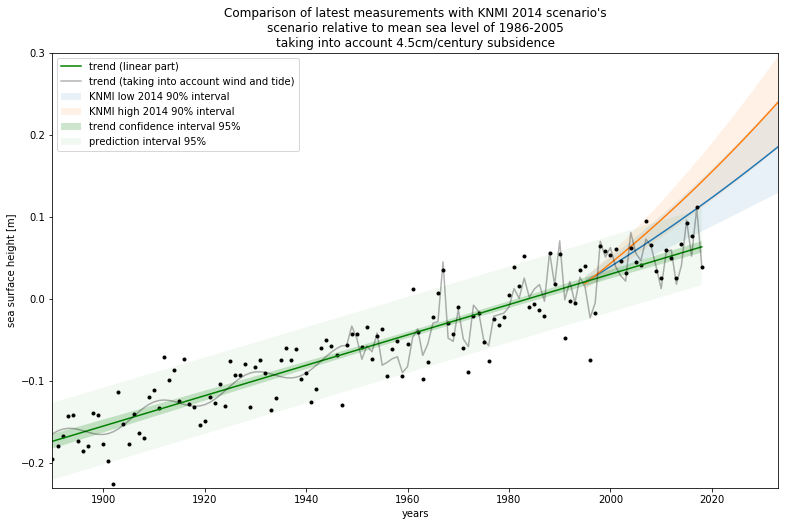

In [9]:
fig, ax = plt.subplots(figsize=(13, 8))
for i, row in scenarios_df[scenarios_df.organization == 'KNMI'].iterrows():
    fill = ax.fill_between(
        row['interp_dates'], 
        row['correction'](row['interp_dates'], row['interp_min']), 
        row['correction'](row['interp_dates'], row['interp_max']), 
        alpha=0.1,
        label='{} {} {} 90% interval'.format(row['organization'], row['scenario'], row['name'])
    )
    color = fill.get_facecolor()[0].copy()
    color[-1] = 1
    ax.plot(
        row['interp_dates'], 
        row['correction'](row['interp_dates'], row['interp_mean']),
        color=color
    )

ax.plot(slr_df.index, slr_df['height_m'], 'k.')    
ax.plot(slr_df.index, slr_df.predicted_linear_mean_wind / 1000, color='green', label='trend (linear part)')
ax.fill_between(
    slr_df.index, slr_df.predicted_linear_mean_wind_ci_025/1000, 
    slr_df.predicted_linear_mean_wind_ci_975/1000, 
    alpha=0.2, 
    facecolor='green', 
    label='trend confidence interval 95%'
)
ax.fill_between(
    slr_df.index, 
    slr_df.predicted_linear_mean_wind_pi_025/1000, 
    slr_df.predicted_linear_mean_wind_pi_975/1000, 
    alpha=0.05, 
    facecolor='green', 
    label='prediction interval 95%'
)
ax.plot(slr_df.index, slr_df.predicted_linear_with_wind / 1000, 'k-', alpha=0.3, label='trend (taking into account wind and tide)')
ax.set_xlim(datetime.datetime(1980, 1, 1), datetime.datetime(2100, 1, 1))
ax.set_title(
    "Comparison of latest measurements with KNMI 2014 scenario\'s" + 
    "\n" + 
    "scenario relative to mean sea level of 1986-2005" + 
    "\n" +
    "taking into account 4.5cm/century subsidence"
)
ax.set_xlabel('years')
ax.set_ylabel('sea surface height [m]')
ax.set_xlim(datetime.datetime(1890, 1, 1), datetime.datetime(2018 + 15, 1, 1))
ax.legend()

_ = ax.set_ylim(-0.23, 0.3)
fig.savefig('scenarios-with-ci.pdf')

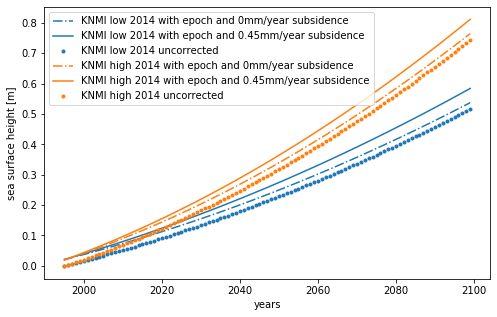

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
# pick the low scenario
for i, row in scenarios_df[
        scenarios_df['organization'] == 'KNMI'
    ].iterrows():
    # show differences with and without subsidence and epoch fix        
    line, = ax.plot(
        row['interp_dates'], 
        row['correction'](row['interp_dates'], row['interp_mean'], subsidence_rate=0),
        '-.',
        label='{} {} {} with epoch and 0mm/year subsidence'.format(row['organization'], row['scenario'], row['name'])
    )
    color = line.get_color()
    ax.plot(
        row['interp_dates'], 
        row['correction'](row['interp_dates'], row['interp_mean'], subsidence_rate=0.00045),
        '-',
        color=color,
        label='{} {} {} with epoch and 0.45mm/year subsidence'.format(row['organization'], row['scenario'], row['name'])
    )
    ax.plot(
        row['interp_dates'], 
        row['interp_mean'],
        '.',
        color=color,
        label='{} {} {} uncorrected'.format(row['organization'], row['scenario'], row['name'])
    )
    ax.legend()
    ax.set_xlabel('years')
    ax.set_ylabel('sea surface height [m]')
    ax.legend(loc='best')
    # show the row
fig.savefig('scenarios-with-correction.pdf')
